# Decision Trees and Ensemble Tree Methods

## Introduction

In this section we look at tree based models, specifically the standard Decision Tree Classifier and three ensemble extensions of this method, Random Forrest, Gradient Boosted Tree and XGBoost. We compare the models on both the original and balanced datasets and then tune the hyperparameters of the ensemble methods using a package called Optuna in an attempt to get improved predictions.

## Load Data

Here we load the pre-processed data processed in the "Data Transformation + Logistic Regression" section. We have the train and test sets for both the original data and the balanced SMOTE data already seperated and ready to use in our models straight away.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('jfk_flight_data.csv')
JFKdata = df.to_numpy()
# Import pre-prepared data
# Unbalanced Data
df_X_train = pd.read_csv('X_train.csv')
df_X_test = pd.read_csv('X_test.csv')
df_y_train = pd.read_csv('y_train.csv')
df_y_test = pd.read_csv('y_test.csv')

# Balanced Data
df_X_smote_train = pd.read_csv('X_smote_train.csv')
df_X_smote_test = pd.read_csv('X_smote_test.csv')
df_y_smote_train = pd.read_csv('y_smote_train.csv')
df_y_smote_test = pd.read_csv('y_smote_test.csv')

# Convert to numpy arrays
X_train = df_X_train.to_numpy()
X_test = df_X_test.to_numpy()
y_train = df_y_train.to_numpy().ravel()
y_test = df_y_test.to_numpy().ravel()

# Balanced Data
X_smote_train = df_X_smote_train.to_numpy()
X_smote_test = df_X_smote_test.to_numpy()
y_smote_train = df_y_smote_train.to_numpy().ravel()
y_smote_test = df_y_smote_test.to_numpy().ravel()



## Import Packages

In [2]:
from IPython.display import display
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
!pip install xgboost
!pip install optuna
import xgboost as xgb
from xgboost import XGBClassifier
import optuna
%matplotlib inline

  Using cached xgboost-2.0.1-py3-none-manylinux2014_x86_64.whl (297.1 MB)
  Using cached optuna-3.4.0-py3-none-any.whl (409 kB)
  Using cached colorlog-6.7.0-py2.py3-none-any.whl (11 kB)


## Out of the Box Implementations

To start our analysis we first train the four different models on the original data using the default parameters recommended by the sklearn package to get a baseline for where the models are at. The only parameter we set is the random_state = 1 which is just for reproducibility so we get the same model every time we run the code. We then make predictions on the test dataset for each model and compute the accuracy, precision, recall and F1 score of the predictions when compared to the actual values.

In [3]:
# Create Models
DT = DecisionTreeClassifier(random_state = 1)
RF = RandomForestClassifier(random_state = 1)
GBT = GradientBoostingClassifier(random_state = 1)
XGB = XGBClassifier(random_state = 1)

# Train models
DT.fit(X_train, y_train)
RF.fit(X_train, y_train)
GBT.fit(X_train, y_train)
XGB.fit(X_train, y_train)

# Make predictions
DTpredicted = DT.predict(X_test)
RFpredicted = RF.predict(X_test)
GBTpredicted = GBT.predict(X_test)
XGBpredicted = XGB.predict(X_test)

# Initialize dictionaries to store the results
results = {
    'Method': ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'Accuracy': [accuracy_score(y_test, DTpredicted), accuracy_score(y_test, RFpredicted), accuracy_score(y_test, GBTpredicted), accuracy_score(y_test, XGBpredicted)],
    'Precision': [precision_score(y_test, DTpredicted, average='weighted'), precision_score(y_test, RFpredicted, average='weighted'), precision_score(y_test, GBTpredicted, average='weighted'), precision_score(y_test, XGBpredicted, average='weighted')],
    'Recall': [recall_score(y_test, DTpredicted, average='weighted'), recall_score(y_test, RFpredicted, average='weighted'), recall_score(y_test, GBTpredicted, average='weighted'), recall_score(y_test, XGBpredicted, average='weighted')],
    'F1 Score': [f1_score(y_test, DTpredicted, average='weighted'), f1_score(y_test, RFpredicted, average='weighted'), f1_score(y_test, GBTpredicted, average='weighted'), f1_score(y_test, XGBpredicted, average='weighted')]
}

# Create a Pandas DataFrame from the results dictionary
results_df = pd.DataFrame(results)

# Display the results table with rounded values (6 decimal places)
pd.set_option("display.precision", 6)
display(results_df)

,Method,Accuracy,Precision,Recall,F1 Score
0,Decision Tree,0.746063,0.756634,0.746063,0.751045
1,Random Forest,0.825234,0.796836,0.825234,0.792416
2,Gradient Boosting,0.818600,0.796842,0.818600,0.753918
3,XGBoost,0.830869,0.807256,0.830869,0.795977


Its worth mentioning at this point what these metrics actually relate to. Accuracy is simply a measure of how many of the predictions were correct, Precision is a measure of how many positive predictions were correct, Recall looks at the actual positives and gives a score for how well the model predicts these and finally the F1 score combines precision and recall into a single metric. Its useful to display different metrics so we know our models are predicting well across the board and not just predicting every case as not delayed and achiving 0.8 accuracy

We can see from these results that XGBoost is currently performing best, with a slightly better performance than Random Forrest in all metrics

## Out of the Box Implementations on Balanced Data

We now train four new models on the balanced dataset, again with default parameters, hoping to see improvement.

In [4]:
# Create models
DTB = DecisionTreeClassifier(random_state = 1)
RFB = RandomForestClassifier(random_state = 1)
GBTB = GradientBoostingClassifier(random_state = 1)
XGBB = XGBClassifier(random_state = 1)

# Train models
DTB.fit(X_smote_train, y_smote_train)
RFB.fit(X_smote_train, y_smote_train)
GBTB.fit(X_smote_train, y_smote_train)
XGBB.fit(X_smote_train, y_smote_train)

# Make predictions
DTpredicted = DTB.predict(X_smote_test)
RFpredicted = RFB.predict(X_smote_test)
GBTpredicted = GBTB.predict(X_smote_test)
XGBpredicted = XGBB.predict(X_smote_test)

# Initialize dictionaries to store the results
results = {
    'Method': ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'Accuracy': [accuracy_score(y_smote_test, DTpredicted), accuracy_score(y_smote_test, RFpredicted), accuracy_score(y_smote_test, GBTpredicted), accuracy_score(y_smote_test, XGBpredicted)],
    'Precision': [precision_score(y_smote_test, DTpredicted, average='weighted'), precision_score(y_smote_test, RFpredicted, average='weighted'), precision_score(y_smote_test, GBTpredicted, average='weighted'), precision_score(y_smote_test, XGBpredicted, average='weighted')],
    'Recall': [recall_score(y_smote_test, DTpredicted, average='weighted'), recall_score(y_smote_test, RFpredicted, average='weighted'), recall_score(y_smote_test, GBTpredicted, average='weighted'), recall_score(y_smote_test, XGBpredicted, average='weighted')],
    'F1 Score': [f1_score(y_smote_test, DTpredicted, average='weighted'), f1_score(y_smote_test, RFpredicted, average='weighted'), f1_score(y_smote_test, GBTpredicted, average='weighted'), f1_score(y_smote_test, XGBpredicted, average='weighted')]
}

# Create a Pandas DataFrame from the results dictionary
results_df = pd.DataFrame(results)

# Display the results table with rounded values (6 decimal places)
pd.set_option("display.precision", 6)
display(results_df)

,Method,Accuracy,Precision,Recall,F1 Score
0,Decision Tree,0.830405,0.830575,0.830405,0.830383
1,Random Forest,0.887503,0.888189,0.887503,0.887454
2,Gradient Boosting,0.729491,0.729885,0.729491,0.729374
3,XGBoost,0.854777,0.860349,0.854777,0.854213


This table gives very interesting results, as we can see all methods improved in all areas except the Gradient Boosted Tree which performed worse in all areas. This could be due to the fact that as we oversample the minority class (delayed flights) the gradient boosted tree is overfitting to this class.

Random Forrest is less sensitive to the distribution of the data and adapts well to the synthetic data brought in by SMOTE, it has shown itself to be an adaptable model out of the box, performing well on both datasets.

the standard decision tree method has improved quite significantly and XGBoost also made improvements showing that SMOTE has a positive impact on the dataset as the original was inherently unbalanced. The results give us optimism that once the gradient boosted tree has been tuned to the data, it too will improve in performance.

# 10-fold Cross Validation Accuracy

Cross-validation is a more robust way to understand how are models are performing. The metrics above are useful to give us a rough, quick idea of how the models are doing but they can vary significantly with the randomness of the models and can also be misleading when working with imbalanced classes, which we are doing. 10-fold cross-validation divides the data into ten parts. It trains the model on nine of them and tests it on the remaining part, repeating this process ten times. This way, it assesses the model's performance from multiple angles and provides a more meaningful evaluation.

This section takes a few minutes to run so the results have been pre-calculated for convenience.

In [5]:
# Create a KFold cross-validator with shuffling (optional)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [63]:
# Perform 10-fold cross-validation on Decision Tree
accuracyDT = cross_val_score(DT, X_train, y_train, cv=kf, scoring='accuracy').mean()
accuracyDT_B = cross_val_score(DTB, X_smote_train, y_smote_train, cv=kf, scoring='accuracy').mean()

In [50]:
# Perform 10-fold cross-validation on Random Forrest
accuracyRF = cross_val_score(RF, X_train, y_train, cv=kf, scoring='accuracy').mean()
accuracyRF_B = cross_val_score(RFB, X_smote_train, y_smote_train, cv=kf, scoring='accuracy').mean()

In [43]:
# Perform 10-fold cross-validation on Gradient Boosted Tree
accuracyGBT = cross_val_score(GBT, X_train, y_train, cv=kf, scoring='accuracy').mean()
accuracyGBT_B = cross_val_score(GBTB, X_smote_train, y_smote_train, cv=kf, scoring='accuracy').mean()

In [37]:
# Perform 10-fold cross-validation on Gradient Boosted Tree
accuracyXGB = cross_val_score(XGB, X_train, y_train, cv=kf, scoring='accuracy').mean()
accuracyXGB_B = cross_val_score(XGBB, X_smote_train, y_smote_train, cv=kf, scoring='accuracy').mean()

In [6]:
# LIST OF PRECALCULATED ACCURACIES:
accuracyDT = 0.7418245202020021
accuracyRF = 0.8231537529492842
accuracyGBT = 0.8177484937816557
accuracyXGB = 0.8291885234943226
accuracyDT_B = 0.8245180883899008
accuracyRF_B = 0.8853018477167632
accuracyGBT_B = 0.7274956867337232
accuracyXGB_B = 0.8562345789666373

In [7]:
CVresults = {
    'Method': ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'Accuracy': [accuracyDT, accuracyRF, accuracyGBT, accuracyXGB],
    'Accuracy Balanced' : [accuracyDT_B, accuracyRF_B, accuracyGBT_B, accuracyXGB_B],
}
CVresults_df = pd.DataFrame(CVresults)
display(CVresults_df)


,Method,Accuracy,Accuracy Balanced
0,Decision Tree,0.741825,0.824518
1,Random Forest,0.823154,0.885302
2,Gradient Boosting,0.817748,0.727496
3,XGBoost,0.829189,0.856235


The cross validation results provide more evidence that Random Forrest is the best performer out of the box and that the SMOTE dataset is improving performance. Again, gradient boosting is struggling with the synthetic data showing limited adaptability to different datasets with no parameter tuning. 

## ROC curve

The ROC (Receiver Operating Characteristic) curve is another tool used to assess the performance of a binary classification model, in the code below we collect probabilities from each model for how confident they are a given flight is delayed. These probabilities are used to calculate the true positive rate and the false positive rate of flight delay predictions which we use to plot the curve. More information about the context of this curve is given in the evaluation section but for now we use it as another tool to evaluate model performance.

In [8]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

DTpredicted_probs = DT.predict_proba(X_test)
RFpredicted_probs = RF.predict_proba(X_test)
GBTpredicted_probs = GBT.predict_proba(X_test)
XGBpredicted_probs = XGB.predict_proba(X_test)
DTpredicted_probs_B = DTB.predict_proba(X_smote_test)
RFpredicted_probs_B = RFB.predict_proba(X_smote_test)
GBTpredicted_probs_B = GBTB.predict_proba(X_smote_test)
XGBpredicted_probs_B = XGBB.predict_proba(X_smote_test)

DT_fpr, DT_tpr, _ = roc_curve(y_test, DTpredicted_probs[:,1])
RF_fpr, RF_tpr, _ = roc_curve(y_test, RFpredicted_probs[:,1]) 
GBT_fpr, GBT_tpr, _ = roc_curve(y_test, GBTpredicted_probs[:,1])
XGB_fpr, XGB_tpr, _ = roc_curve(y_test, XGBpredicted_probs[:,1])
DT_fpr_B, DT_tpr_B, _ = roc_curve(y_smote_test, DTpredicted_probs_B[:,1])
RF_fpr_B, RF_tpr_B, _ = roc_curve(y_smote_test, RFpredicted_probs_B[:,1]) 
GBT_fpr_B, GBT_tpr_B, _ = roc_curve(y_smote_test, GBTpredicted_probs_B[:,1])
XGB_fpr_B, XGB_tpr_B, _ = roc_curve(y_smote_test, XGBpredicted_probs_B[:,1])

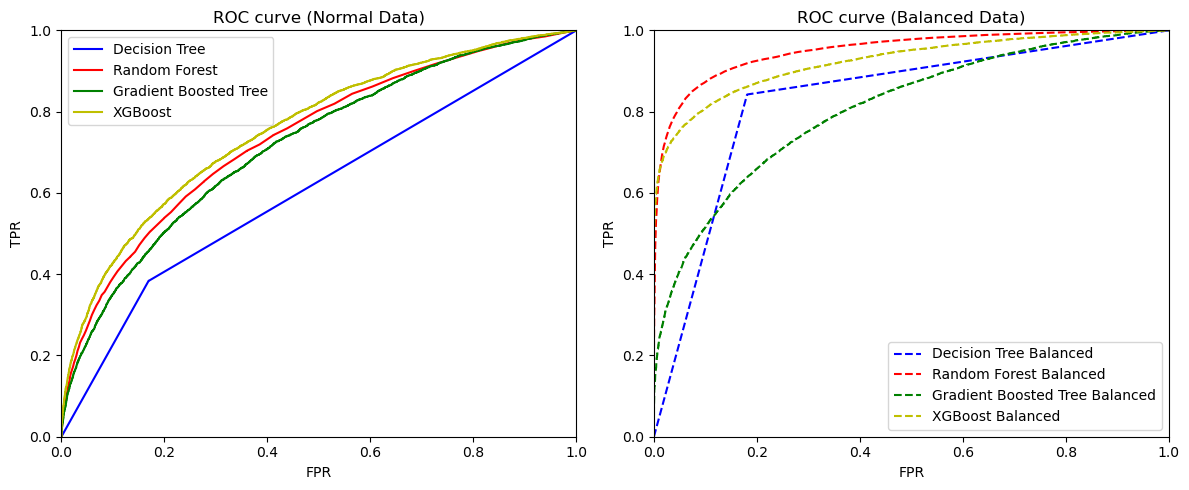

In [9]:
# Create a subplot with 1 row and 2 columns
plt.figure(figsize=(12, 5))

# Plot the ROC curve for normal data in the first subplot
plt.subplot(1, 2, 1)
plt.plot(DT_fpr, DT_tpr, 'b', label="Decision Tree")
plt.plot(RF_fpr, RF_tpr, 'r', label="Random Forest")
plt.plot(GBT_fpr, GBT_tpr, 'g', label="Gradient Boosted Tree")
plt.plot(XGB_fpr, XGB_tpr, 'y', label="XGBoost")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve (Normal Data)')
plt.legend()

# Plot the ROC curve for balanced data in the second subplot
plt.subplot(1, 2, 2)
plt.plot(DT_fpr_B, DT_tpr_B, 'b', linestyle='--', label="Decision Tree Balanced")
plt.plot(RF_fpr_B, RF_tpr_B, 'r', linestyle='--', label="Random Forest Balanced")
plt.plot(GBT_fpr_B, GBT_tpr_B, 'g', linestyle='--', label="Gradient Boosted Tree Balanced")
plt.plot(XGB_fpr_B, XGB_tpr_B, 'y', linestyle='--', label="XGBoost Balanced")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve (Balanced Data)')
plt.legend()

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Display the plot
plt.show()

In an ROC curve, the closer a model gets to the top left, the better it is predicting. We can see that for the original dataset XGBoost is performing best, however with the SMOTE data all for models make improvement and Random Forrest performs exceptionally well.

It seems strange that the decision tree has a sharp edge whereas the other 3 ensemble methods are smooth, this could be because the decision tree is a much simpler model with sharp decision boundaries, whereas the ensemble methods combine and average multiple base models which smooth out the curve.

In [10]:
ROCresults = {
    'Method': ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'ROC-AUC Score': [roc_auc_score(y_test, DTpredicted_probs[:,1]), roc_auc_score(y_test, RFpredicted_probs[:,1]), roc_auc_score(y_test, GBTpredicted_probs[:,1]), roc_auc_score(y_test, XGBpredicted_probs[:,1])],
    'ROC-AUC Score Balanced' : [roc_auc_score(y_smote_test, DTpredicted_probs_B[:,1]), roc_auc_score(y_smote_test, RFpredicted_probs_B[:,1]), roc_auc_score(y_smote_test, GBTpredicted_probs_B[:,1]), roc_auc_score(y_smote_test, XGBpredicted_probs_B[:,1])],
}
ROCresults_df = pd.DataFrame(ROCresults)
display(ROCresults_df)

,Method,ROC-AUC Score,ROC-AUC Score Balanced
0,Decision Tree,0.607057,0.830586
1,Random Forest,0.737541,0.950862
2,Gradient Boosting,0.718396,0.807618
3,XGBoost,0.757471,0.923367


The ROC-AUC score (area under ROC curve) gives a numerical value for how well each model performs in this metric. We can see that for this score, the balancing of the data makes a huge impact. However, we must take these comparisons with a pinch of salt. The original data is highly unbalanced therefore its harder for models to get good ROC-AUC scores but the models on the balanced data are trained and also tested on the balanced data. This means that as the data is closer to a 50/50 split for delayed and on time flights, it is easier to even out the true positives and false positives and get much better ROC_AUC scores.

As the models have generally performed better on the balanced data, we will now only look at the models on the SMOTE dataset going forward and attempt to tune the hyperparameters to this dataset to maximise the accuracy.

# Feature Importance

Feature selection is a very common reccomended improvement of most binary classification models. In this section we will briefly look at the feature importances for each model but ultimatly we wont remove any features as we are only using 20 features to begin with which the models seem to be able to handel fairly well. Aslo, as we will see, the results from our feature analysis are largly inconclusive.

We conduct the analysis by plotting the 10 most important features for each model in importance order.

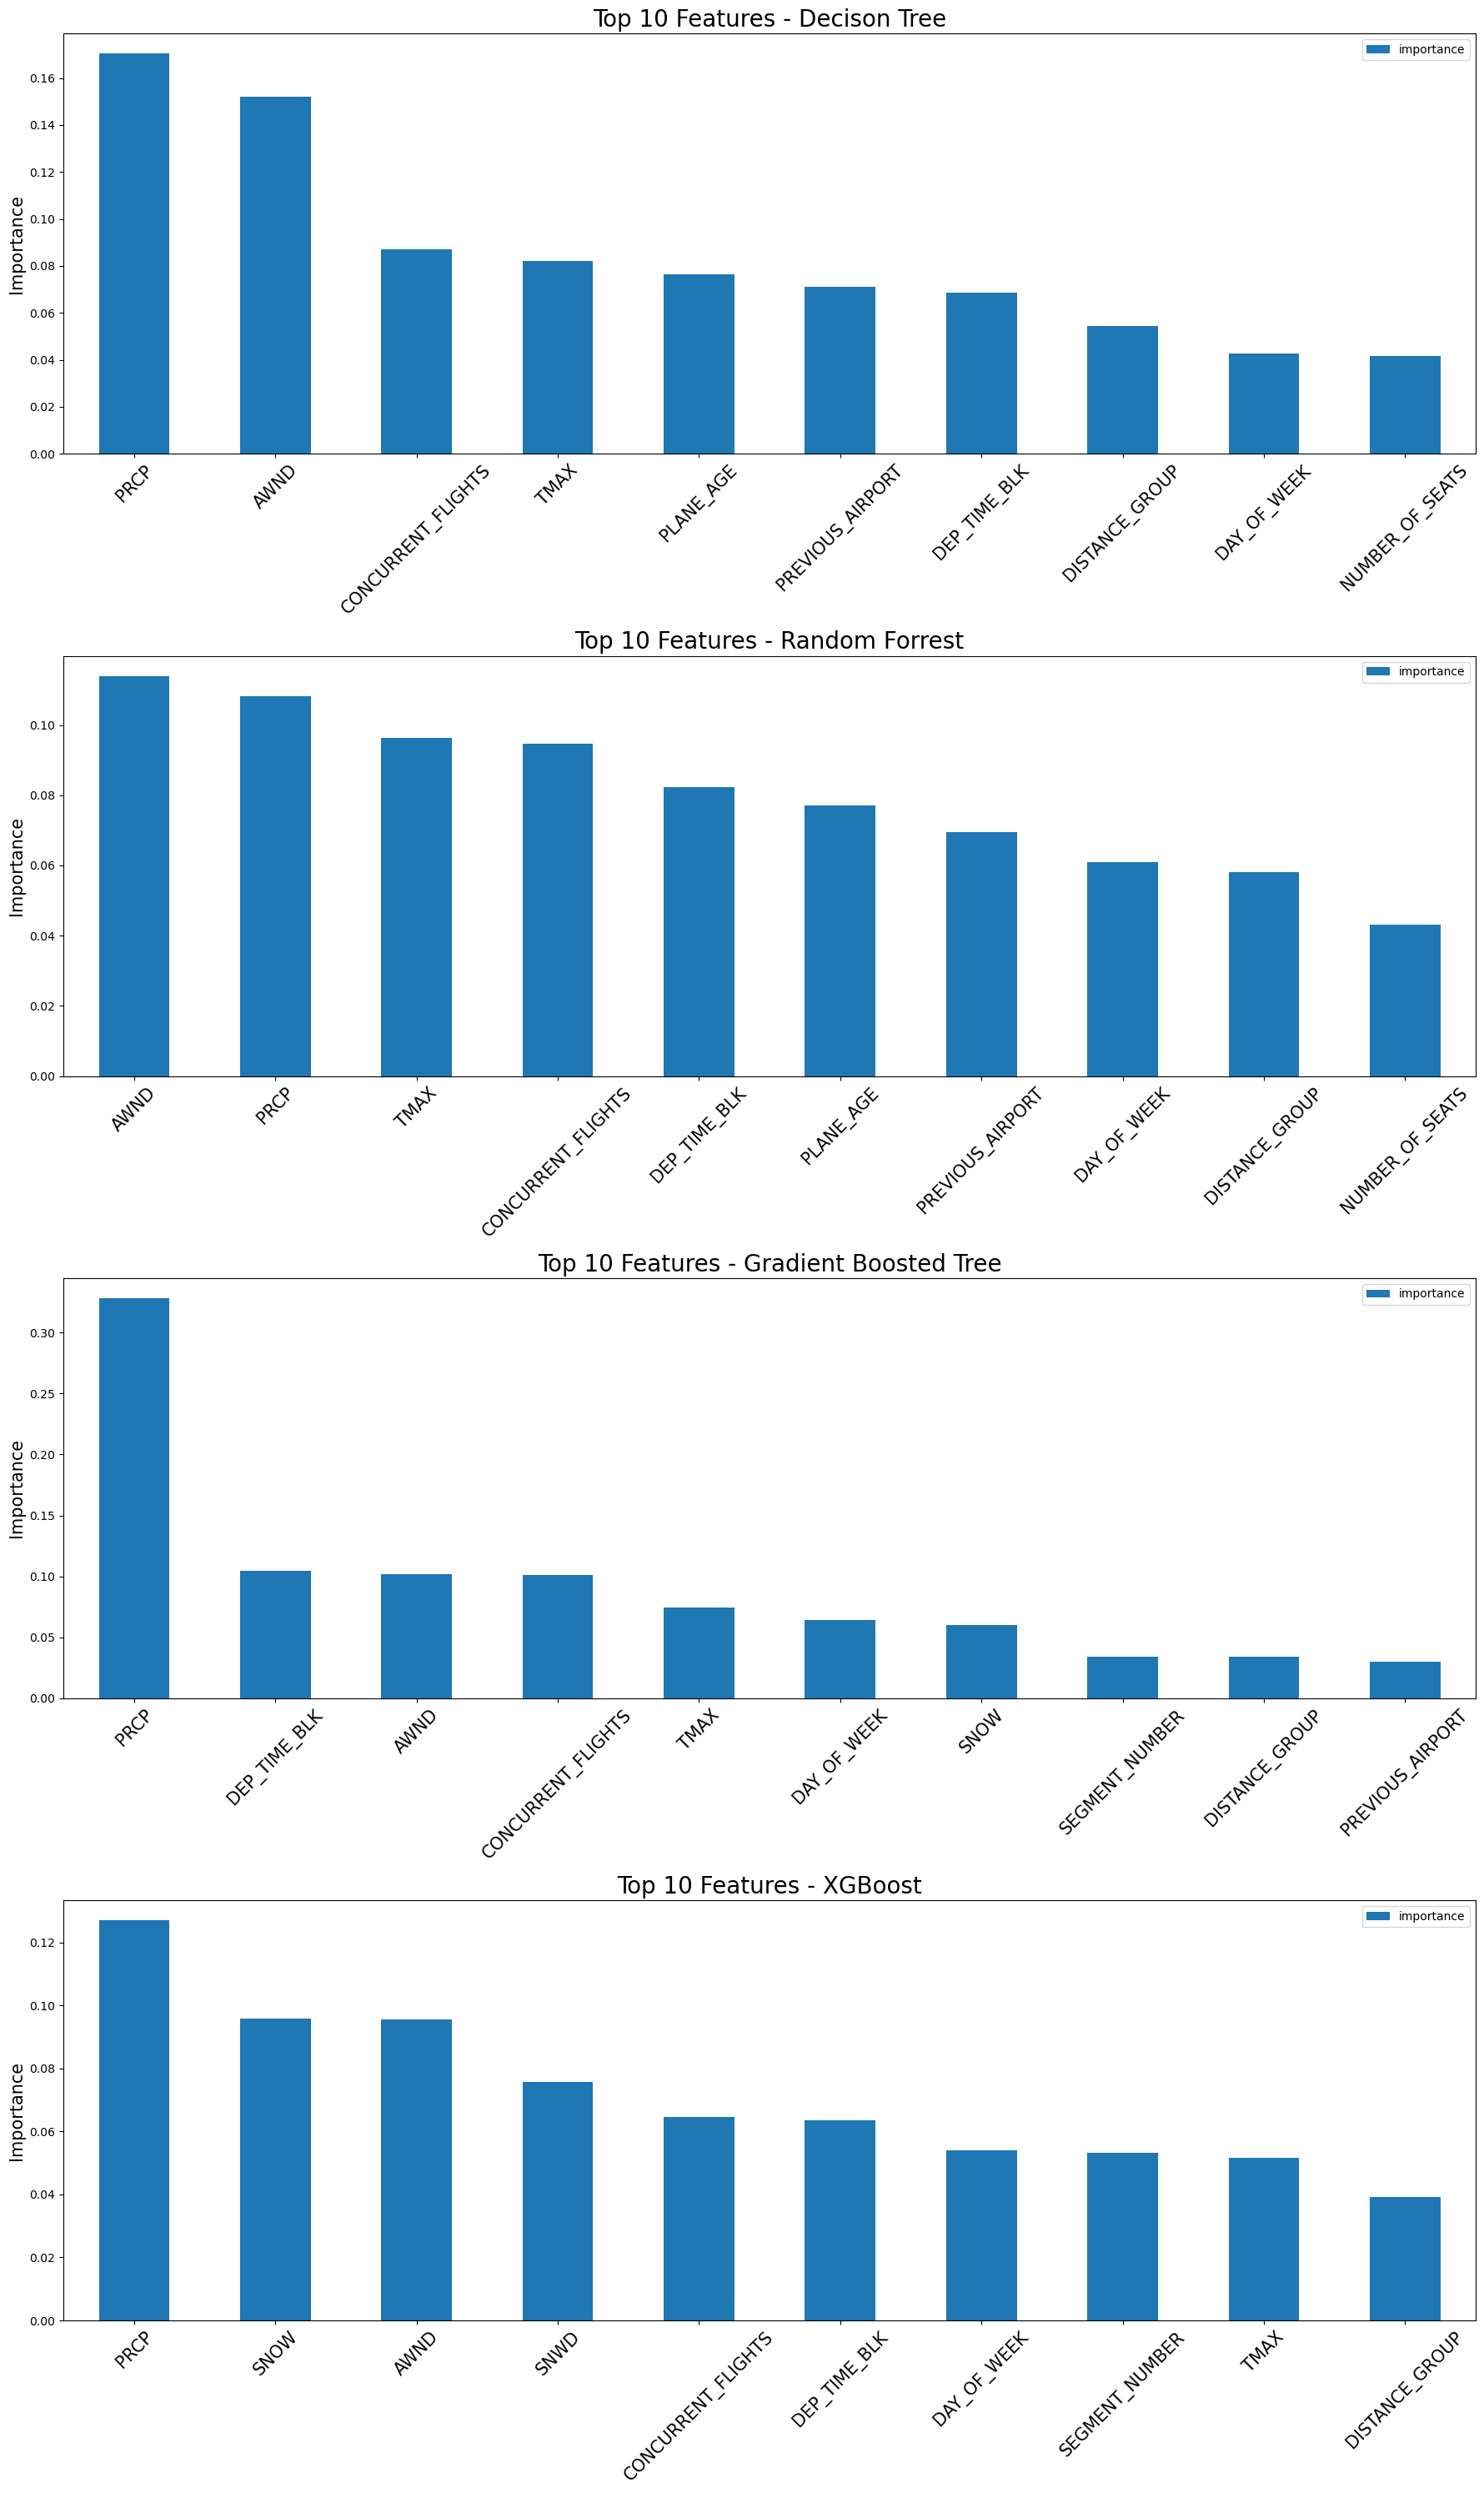

In [11]:
model_names = ['Decison Tree', 'Random Forrest', 'Gradient Boosted Tree', 'XGBoost']
models = [DTB, RFB, GBTB, XGBB]  # Replace these with your actual model instances

# Create subplots for the stacked plots
fig, axes = plt.subplots(4, 1, figsize=(18, 30))
i = -1
# Loop through each model and plot feature importances
for model in models:
    i += 1
    feature_importances = pd.DataFrame({'importance': model.feature_importances_}, index=df_X_smote_train.columns)
    top_features = feature_importances.nlargest(10, columns=['importance'])
    ax = axes[i]
    top_features.plot(kind='bar', ax=ax)
    ax.set_title(f'Top 10 Features - {model_names[i]}', fontsize = 20)
    ax.set_ylabel('Importance', fontsize = 15)
    ax.tick_params(axis='x', labelrotation=45, labelsize=15)  # Rotate x-axis labels and set font size

# Adjust spacing between subplots
plt.tight_layout()

# Show the stacked plots
plt.show()

The first thing we can notice from this analysis is the massive importance that Gradiant Boosted Trees puts on PRCP (precipitation) compared to the other features. This overfitting to one feature could be the reason why this model has been performing so poorly as the feature importance of other models, such as Random Forrest, is much more evenly spread. 

Its difficult to drawn too many conclusions about what features are most important from these graphs as the models vary in what they consider important so, as we are working with only 20, we will keep them all in as dimensionality reduction at this stage isnt really neccesary. It is interesting to see that the models with a more even spread tend to perform better suggesting that selecting and weighting the features for each model individually would likely improve accuracy. However in order to compare how each of the models respond to parameter tuning its best to use the same features for each model.

## Tuning Random Forrest

Random forrest is the most difficult model to tune which we will demonstarte in the following section. This is because the default implementation already generalises very well to many different datasets inluding ours. Out of the box we are already using the best n_estimators and max_depth parameters, arguably the two most important parameters

### Tuning n_estimators

Below we iterate through the list of parameters we want to check and compute the reliable cross validation score for both the train and test sets, keeping the rest of the parameters constant.

This takes a few minutes so again the results have been precomputed.

In [32]:
scores=[]
num_trees = [1, 3, 5, 10, 15, 20, 35, 50, 100, 150]
trainscores=[]
for ntrees in num_trees:
    print(ntrees)
    tmpcf=RandomForestClassifier(n_estimators=ntrees)
    tmp_trained_model= tmpcf.fit(X_smote_train, y_smote_train)
    tmp_test_CV = cross_val_score(tmpcf, X_smote_test, y_smote_test, cv=kf, scoring='accuracy')
    tmp_train_CV = cross_val_score(tmpcf, X_smote_train, y_smote_train, cv=kf, scoring='accuracy')
    scores.append(tmp_test_CV.mean())
    trainscores.append(tmp_train_CV.mean())


1
3
5
10
15
20
35
50
100
150


In [14]:
# PRECALCULATED RESULTS
num_trees = [1, 3, 5, 10, 15, 20, 35, 50, 100, 150]
scores = [0.6926492224587213, 0.7378942054530238, 0.7607878575542483, 0.7854308970506896, 0.7982700983629897, 0.8029029588589316, 0.8095567075045558, 0.812218153510601, 0.8190197217982828, 0.8178122790161344]
trainscores = [0.7722485875664185, 0.8193428892663792, 0.8412573214846436, 0.8609045325285972, 0.8687597238082431, 0.8749330095902556, 0.8787959157249758, 0.8824185378793278, 0.8854743555941162, 0.8860719709763236]

In [15]:
scoresb=scores[0:10]
scoresb=pd.DataFrame(scoresb).transpose() # Convert to data frame for naming
scoresb.columns=[str(x) for x in num_trees[:10]] # The number of trees that we used

trainscoresb=trainscores[0:10]
trainscoresb=pd.DataFrame(trainscoresb).transpose() # Convert to data frame for naming
trainscoresb.columns=[str(x) for x in num_trees[:10]] # The number of trees that we used

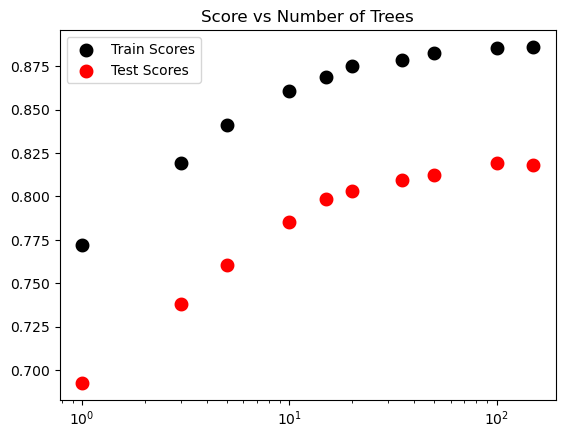

In [16]:
# Create a figure and axes for your plot
fig, ax = plt.subplots()

# Create a scatter plot on the same axes
ax.scatter(num_trees, trainscoresb, c='black', linewidths=4, label = 'Train Scores')
ax.scatter(num_trees, scoresb, c='red', linewidths=4, label = 'Test Scores')

ax.set_xscale('log')
ax.legend()
# Set the title
ax.set_title("Score vs Number of Trees", loc="center")

# Show the combined plot
plt.show()

We can see that as we approach 100 trees the cross validation score begins to plateau. As this parameter is set to 100 by default, there is no improvement to be made here as we were already using the best parameter.

This plot is still useful though as we can see that reducing the number of estimators to 10 doesnt have a massive effect on the accuracy. With 10 estimators the model runs much faster allowing us to tune other parameters much easier so in the next sections we will use 10 estimators to tune the models and then go back to 100 estimators in the final model. This method will mean that we wont find as good parameters as we would have if we run the tests with 100 estimators as the parameters will be tuned to work with a model with 10 estimators. However a trade off has to be made between this and doing less tuning while we wait for the 100 estimator forrests to run every time. Luckily for us, good parameters for a model with 10 estimators are usually also good parameters for a model with 100 estimators so we do improve the accurcies in the next section.

### Tuning Max Depth

We test tuning max depth in the same way.

Even using n_estimators = 10 this still takes a few minutes, precalcuated results are below.

In [25]:
scoresMD = []
depths = [5,6,7,8,10,15,20,30, 75,100, None]
trainscoresMD = []
for mdepth in depths:
    print(mdepth)
    tmpcf=RandomForestClassifier(n_estimators=10, max_depth = mdepth)
    tmp_trained_model= tmpcf.fit(X_smote_train, y_smote_train)
    tmp_y_pred = tmp_trained_model.predict(X_smote_test)
    tmp_y_pred_train = tmp_trained_model.predict(X_smote_train)
    tmp_test_CV = cross_val_score(tmpcf, X_smote_test, y_smote_test, cv=kf, scoring='accuracy')
    tmp_train_CV = cross_val_score(tmpcf, X_smote_train, y_smote_train, cv=kf, scoring='accuracy')
    scoresMD.append(tmp_test_CV.mean())
    trainscoresMD.append(tmp_train_CV.mean())

5
6
7
8
10
15
20
30
75
100
None


In [17]:
# PRECALCULATED RESULTS
depths = [5,6,7,8,10,15,20,30, 75,100, None]
scoresMD = [0.6778879041670003, 0.6871286484014815, 0.6943986159280523, 0.7018411308154024, 0.7189679581974604, 0.759038069267497, 0.7807977814419533, 0.7851106211595653, 0.7847657208096599, 0.7815126986037919, 0.78338563955502]
trainscoresMD = [0.6749737392462124, 0.6825886268082674, 0.6922058233064954, 0.702525463370008, 0.7261279678291779, 0.7968308416659078, 0.8407706254959546, 0.8615822434565719, 0.8628021104495567, 0.8627343203027484, 0.8621736848838293]

In [18]:
scoresMDb=scoresMD[0:11]
scoresMDb=pd.DataFrame(scoresMDb).transpose() # Convert to data frame for naming
scoresMDb.columns=[str(x) for x in depths[:11]] # The number of trees that we used

trainscoresMDb=trainscoresMD[0:11]
trainscoresMDb=pd.DataFrame(trainscoresMDb).transpose() # Convert to data frame for naming
trainscoresMDb.columns=[str(x) for x in depths[:11]] # The number of trees that we used

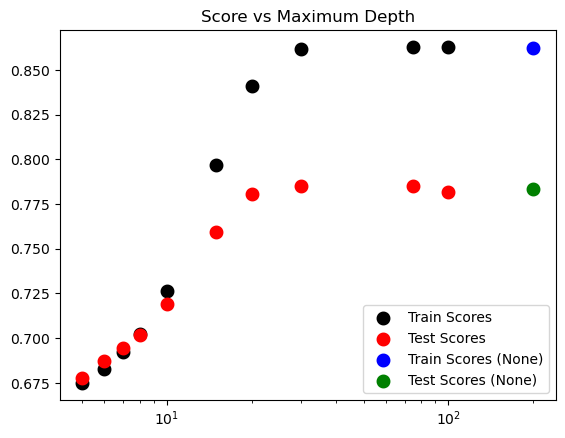

In [19]:
# Create a figure and axes for your plot
fig, ax = plt.subplots()

# Create a scatter plot on the same axes
ax.scatter(depths, trainscoresMDb, c='black', linewidths=4, label = 'Train Scores')
ax.scatter(depths, scoresMDb, c='red', linewidths=4, label = 'Test Scores')

# Add a custom label for "None" depth value, plot out of the way to the right at 200
ax.scatter(200, [trainscoresMD[10]], c='blue', linewidths=4, label='Train Scores (None)')
ax.scatter(200, [scoresMD[10]], c='green', linewidths=4, label='Test Scores (None)')


ax.set_xscale('log')
ax.legend()
# Set the title
ax.set_title("Score vs Maximum Depth", loc="center")

# Show the combined plot
plt.show()

Again, we can see here that once we have got to a maximum depth of 30 there is no improvement to be made from increasing any further. The default parameter of max_depth = None is on par with this score so this is another parameter we are unable to tune.

This method of hyperparameter tuning, eyeballing graphs, is a slow process and isnt making any improvement so far. Also its impossible for us to tune multiple parameters at once to see which combination of parameters gives the best accuracy. Even if we did find parameters that we could make improvements on we would have no solid evidence that our final set of parameters are the best for our dataset as we could have tuned in a different order. In the next section we look at a smarter method for hyperparameter tuning using a library called Optuna that allows us to tune whatever parameters we want simultaneously.

# Optuna

Optuna is an open-source library specifically for hyperparameter tuning and can be used on any machine learning or deep learning framework. It uses Bayesian Optimization to automate the search for the optimal set of hyperparameters. In the objective function we can specify the parameters we want to tune. for numerical parameters we give a range of integer or float values that can be tested and for categorical parameters we can list whatever categories we want to try. Optuna then intelligently explores the search space using Bayesian Optimization and pruning techniques to hone in on the best configuration of parameters that maximise the accuracy.

## Tuning Random Forrest using Optuna

Random Forrest is a poor choice of model to demonstate Optuna as its difficult to find parameters that are not already tuned. Often whenever a new parameter is tried optuna finds that the best value for that parameter was the default parameter. More parameters have been tried that what is shown but below is a simple example with a few parameters of different types.

Its worth running this code as Optuna outputs the progress it makes with each step and tells us which combination of parameters it is trying and the output it produces throughout the study gives us some insight into how it works. The best hyperparameters are also precalculated below for each model so there is no need to wait for optuna to finish the full studies.

In [20]:
import optuna

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to be optimized
    params = {
    'n_estimators': 10,
    'max_depth': None,
    'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 10),
    'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
    'min_weight_fraction_leaf': trial.suggest_float('min_weight_fraction_leaf', 0.000001, 0.5, log=True)
    
}
    # Create classifier with the specified hyperparameters
    model = RandomForestClassifier(**params)

    # Train the model
    model.fit(X_smote_train, y_smote_train)

    # Make predictions on the test data
    y_pred = model.predict(X_smote_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_smote_test, y_pred)

    return accuracy

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_paramsRF = study.best_params
best_accuracy = study.best_value
print("Best Hyperparameters:", best_paramsRF)
print("Best Accuracy:", best_accuracy)

[I 2023-11-07 11:24:51,833] A new study created in memory with name: no-name-f3ba780a-4ff9-4b7f-ae8d-a5a89ab0afb0
[I 2023-11-07 11:24:54,350] Trial 0 finished with value: 0.8415929421622022 and parameters: {'min_samples_split': 4, 'min_samples_leaf': 5, 'criterion': 'entropy', 'min_weight_fraction_leaf': 4.330109907964959e-05}. Best is trial 0 with value: 0.8415929421622022.
[I 2023-11-07 11:24:56,261] Trial 1 finished with value: 0.7843465832080633 and parameters: {'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'gini', 'min_weight_fraction_leaf': 0.00027115087366790853}. Best is trial 0 with value: 0.8415929421622022.
[I 2023-11-07 11:24:58,293] Trial 2 finished with value: 0.7828433426156386 and parameters: {'min_samples_split': 5, 'min_samples_leaf': 9, 'criterion': 'entropy', 'min_weight_fraction_leaf': 0.00031586079689120683}. Best is trial 0 with value: 0.8415929421622022.
[I 2023-11-07 11:25:00,167] Trial 3 finished with value: 0.7715074299514527 and parameters: {'m

Best Hyperparameters: {'min_samples_split': 4, 'min_samples_leaf': 2, 'criterion': 'entropy', 'min_weight_fraction_leaf': 2.0184311991916702e-06}
Best Accuracy: 0.8637719017225659


In [21]:
# PRECOMPUTED BEST PARAMETERS
best_paramsRF = {'min_samples_split': 4, 'min_samples_leaf': 2,
                 'criterion': 'entropy', 'min_weight_fraction_leaf': 2.0184311991916702e-06}

In [22]:
# Change the number of estimators back to 100 and build the tuned classifier
best_paramsRF['n_estimators'] = 100
RFT = RandomForestClassifier(**best_paramsRF)

## Tuning Gradient Boosted Tree

The Gradient Boosted Tree is a model that responds much better to hyperparameter tuning with the essential parameter being Learning Rate. There are many parameters we could tune but to demonstate how easy it is to quickly tune the gradient boosted tree we just tune the three most important ones. Namely, learning rate (controls steps size), max depth (limit to depth of individual trees) and subsample (fraction of data to be sampled in each boosting round).

In [51]:


# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to be optimized
    params = {
        'n_estimators': 10,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.7, log=True),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        
    }
    # Create classifier with the specified hyperparameters
    model = GradientBoostingClassifier(**params)

    # Train the model
    model.fit(X_smote_train, y_smote_train)

    # Make predictions on the test data
    y_pred = model.predict(X_smote_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_smote_test, y_pred)

    return accuracy

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_paramsGBT = study.best_params
best_accuracy = study.best_value
print("Best Hyperparameters:", best_paramsGBT)
print("Best Accuracy:", best_accuracy)

[I 2023-11-06 15:29:09,568] A new study created in memory with name: no-name-30007fb1-dd9b-4f63-a794-1f931ece79b4
[I 2023-11-06 15:29:39,084] Trial 0 finished with value: 0.8588678873308855 and parameters: {'learning_rate': 0.5274145329198491, 'max_depth': 20, 'subsample': 0.6594623987866759}. Best is trial 0 with value: 0.8588678873308855.
[I 2023-11-06 15:29:51,223] Trial 1 finished with value: 0.8526577786539836 and parameters: {'learning_rate': 0.5398226583122919, 'max_depth': 13, 'subsample': 0.7995508070567688}. Best is trial 0 with value: 0.8588678873308855.
[I 2023-11-06 15:29:55,252] Trial 2 finished with value: 0.6908006604401291 and parameters: {'learning_rate': 0.013756649165849637, 'max_depth': 6, 'subsample': 0.7198500417551554}. Best is trial 0 with value: 0.8588678873308855.
[I 2023-11-06 15:30:25,003] Trial 3 finished with value: 0.8665812366002119 and parameters: {'learning_rate': 0.16989242591884315, 'max_depth': 18, 'subsample': 0.8318102101039293}. Best is trial 3 

KeyboardInterrupt: 

In [23]:
# PRECOMPUTED BEST PARAMETERS
best_paramsGBT = {'learning_rate': 0.3879808229402331, 'max_depth': 20, 
                  'subsample': 0.960376669190712}

In [24]:
# Change the number of estimators back to 100 and build the tuned classifier
best_paramsGBT['n_estimators'] = 100
GBTT = GradientBoostingClassifier(**best_paramsGBT)

## Tuning XGBoost

XGBoost is another model that responds well to hyperparameter tuning, it is known for its flexibility and offers a wide range of hyperparameters to optimize. Naturally, this means that it requires more experimentation to choose the most effective set of hyperparameters than the Gradient Boosting Classifier. Below we simultaneouslty test and tune 9 hyperparameters.

In [ ]:

# Define the objective function for Optuna
def objective(trial):
    # Define hyperparameters to optimize
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'max_depth': trial.suggest_int('max_depth', 10, 30),
        'max_leaves': trial.suggest_int('max_leaves', 100, 10000, log=True),
        'max_bin': trial.suggest_int('max_bin', 100, 20000, log=True),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 10),
        'subsample': trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'alpha': trial.suggest_float('alpha', 0, 10),
        'lambda': trial.suggest_float('lambda', 0, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.9),
        'n_estimators': 10,
    }
    # Create an XGBoost classifier with the specified hyperparameters
    model = xgb.XGBClassifier(**params)

    # Train the model
    model.fit(X_smote_train, y_smote_train)

    # Make predictions on the test data
    y_pred = model.predict(X_smote_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_smote_test, y_pred)

    return accuracy

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_paramsXGB = study.best_params
best_accuracy = study.best_value
print("Best Hyperparameters:", best_paramsXGB)
print("Best Accuracy:", best_accuracy)

[I 2023-11-06 15:57:41,907] A new study created in memory with name: no-name-e0a873ed-a179-4826-b7f0-b60e0974bc9e
[I 2023-11-06 15:57:43,777] Trial 0 finished with value: 0.8155449863229749 and parameters: {'booster': 'gbtree', 'max_depth': 26, 'max_leaves': 450, 'max_bin': 19072, 'min_child_weight': 2.718359526294331, 'subsample': 0.32559469947410863, 'colsample_bytree': 0.17226686829058274, 'alpha': 0.39445680336706923, 'lambda': 2.3490906392019784, 'learning_rate': 0.0355602975973245}. Best is trial 0 with value: 0.8155449863229749.
[I 2023-11-06 15:57:46,548] Trial 1 finished with value: 0.7549471401463811 and parameters: {'booster': 'dart', 'max_depth': 30, 'max_leaves': 141, 'max_bin': 4009, 'min_child_weight': 1.1294956925672617, 'subsample': 0.15720718197886666, 'colsample_bytree': 0.9022341947629997, 'alpha': 6.306856889601683, 'lambda': 8.648020360699922, 'learning_rate': 0.2581525523191675}. Best is trial 0 with value: 0.8155449863229749.
[I 2023-11-06 15:57:49,524] Trial 2 

In [25]:
best_paramsXGB = {'booster': 'gbtree', 'max_depth': 30, 'max_leaves': 9778, 'max_bin': 4445, 
 'min_child_weight': 0.4667059553031354, 'subsample': 0.9987863682385675, 'colsample_bytree': 0.9299839000557539, 
 'alpha': 1.0661864066696207, 'lambda': 6.1839362854380315, 'learning_rate': 0.5898642519225155, 'n_estimators': 100}

In [26]:
XGBT = xgb.XGBClassifier(**best_paramsXGB)

## Analysis on Tuned Models

Now that we have tuned our three ensemble models we will re run the analysis from the start to see how the models improved.

Fitting the data to the tuned models takes about six minutes but unfortunatly is neccesary to run the final analysis. This increase in time is likely due to the increased subsample rate in Gradient Boosted Trees and XGBoost.

In [27]:
XGBT.fit(X_smote_train, y_smote_train)# Takes about a minute

XGBClassifier(alpha=1.0661864066696207, base_score=None, booster='gbtree',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9299839000557539, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=6.1839362854380315,
              learning_rate=0.5898642519225155, max_bin=4445,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=9778,
              min_child_weight=0.4667059553031354, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, ...)

In [28]:
GBTT.fit(X_smote_train, y_smote_train)# takes about 5 minutes

GradientBoostingClassifier(learning_rate=0.3879808229402331, max_depth=20,
                           subsample=0.960376669190712)

In [29]:
RFT.fit(X_smote_train, y_smote_train) # only takes a few seconds

RandomForestClassifier(criterion='entropy', min_samples_leaf=2,
                       min_samples_split=4,
                       min_weight_fraction_leaf=2.0184311991916702e-06)

### ROC Curve for Tuned Models 

In [30]:
# Original
DTpredicted_probs = DTB.predict_proba(X_smote_test)
RFpredicted_probs = RFB.predict_proba(X_smote_test)
GBTpredicted_probs = GBTB.predict_proba(X_smote_test)
XGBpredicted_probs = XGBB.predict_proba(X_smote_test)
# Tuned
RFTpredicted_probs = RFT.predict_proba(X_smote_test)
GBTTpredicted_probs = GBTT.predict_proba(X_smote_test)
XGBTpredicted_probs = XGBT.predict_proba(X_smote_test)
# Original
DT_fpr, DT_tpr, _ = roc_curve(y_smote_test, DTpredicted_probs[:,1])
RF_fpr, RF_tpr, _ = roc_curve(y_smote_test, RFpredicted_probs[:,1]) 
GBT_fpr, GBT_tpr, _ = roc_curve(y_smote_test, GBTpredicted_probs[:,1])
XGB_fpr, XGB_tpr, _ = roc_curve(y_smote_test, XGBpredicted_probs[:,1])
# Tuned
RFT_fpr, RFT_tpr, _ = roc_curve(y_smote_test, RFTpredicted_probs[:,1]) 
GBTT_fpr, GBTT_tpr, _ = roc_curve(y_smote_test, GBTTpredicted_probs[:,1])
XGBT_fpr, XGBT_tpr, _ = roc_curve(y_smote_test, XGBTpredicted_probs[:,1])

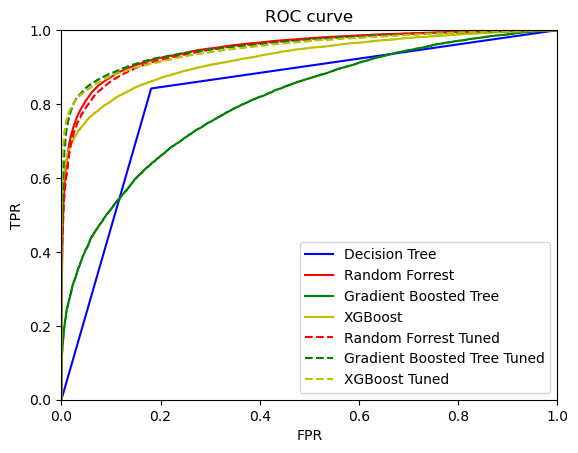

In [31]:
# Original
plt.plot(DT_fpr,DT_tpr,'b', label = "Decision Tree")
plt.plot(RF_fpr,RF_tpr,'r', label = "Random Forrest")
plt.plot(GBT_fpr,GBT_tpr,'g', label = "Gradient Boosted Tree")
plt.plot(XGB_fpr,XGB_tpr,'y', label = "XGBoost")
# Tuned
plt.plot(RFT_fpr,RFT_tpr,'r', linestyle='--', label = "Random Forrest Tuned")
plt.plot(GBTT_fpr,GBTT_tpr,'g', linestyle='--', label = "Gradient Boosted Tree Tuned")
plt.plot(XGBT_fpr,XGBT_tpr,'y', linestyle='--', label = "XGBoost Tuned")
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend()
plt.show()

As the ROC curve shows we have seen massive improvement in performance of the Gradient Boosted Classifier and this improvement has come from only tuning three of its hyperparameters. XGBoost also makes improvement but not as dramatic. It was very difficult to find any way of improving the Random forrest so this model has barely changed. 

In [32]:
ROCresults = {
    'Method': ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'ROC-AUC Score': [roc_auc_score(y_smote_test, DTpredicted_probs[:,1]), roc_auc_score(y_smote_test, RFpredicted_probs[:,1]), roc_auc_score(y_smote_test, GBTpredicted_probs[:,1]), roc_auc_score(y_smote_test, XGBpredicted_probs[:,1])],
    'ROC-AUC Score Tuned' : ['N/A', roc_auc_score(y_smote_test, RFTpredicted_probs[:,1]), roc_auc_score(y_smote_test, GBTTpredicted_probs[:,1]), roc_auc_score(y_smote_test, XGBTpredicted_probs[:,1])],
}
ROCresults_df = pd.DataFrame(ROCresults)
display(ROCresults_df)

,Method,Accuracy,Accuracy Tuned
0,Decision Tree,0.830586,N/A
1,Random Forest,0.950862,0.946915
2,Gradient Boosting,0.807618,0.953205
3,XGBoost,0.923367,0.950418


The numeric ROC-AUC scores give us a suprise "winner" of Gradient Boosted Tree which narrowly beats XGBoost. In a practical sense XGBoost might still be the better choice as it is much faster to fit to the data and has more hyperparameters to tune so with further tuning it might be possible to find an XGBoost model that would beat gradient boosting.

### Accuracy, Precision, Recall and F1 Score for Tuned Models

In [33]:
# Make predictions
DTpredicted = DT.predict(X_smote_test)
RFTpredicted = RFT.predict(X_smote_test)
GBTTpredicted = GBTT.predict(X_smote_test)
XGBTpredicted = XGBT.predict(X_smote_test)
print( "Score: ", DT.score(X_smote_test, y_smote_test))

# Initialize dictionaries to store the results
results = {
    'Method': ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'Accuracy': [accuracy_score(y_smote_test, DTpredicted), accuracy_score(y_smote_test, RFTpredicted), accuracy_score(y_smote_test, GBTTpredicted), accuracy_score(y_smote_test, XGBTpredicted)],
    'Precision': [precision_score(y_smote_test, DTpredicted, average='weighted'), precision_score(y_smote_test, RFTpredicted, average='weighted'), precision_score(y_smote_test, GBTTpredicted, average='weighted'), precision_score(y_smote_test, XGBTpredicted, average='weighted')],
    'Recall': [recall_score(y_smote_test, DTpredicted, average='weighted'), recall_score(y_smote_test, RFTpredicted, average='weighted'), recall_score(y_smote_test, GBTTpredicted, average='weighted'), recall_score(y_smote_test, XGBTpredicted, average='weighted')],
    'F1 Score': [f1_score(y_smote_test, DTpredicted, average='weighted'), f1_score(y_smote_test, RFTpredicted, average='weighted'), f1_score(y_smote_test, GBTTpredicted, average='weighted'), f1_score(y_smote_test, XGBTpredicted, average='weighted')]
}

# Create a Pandas DataFrame from the results dictionary
results_df = pd.DataFrame(results)

# Display the results table with rounded values (6 decimal places)
pd.set_option("display.precision", 6)
display(results_df)

Score:  0.7114270928312674


,Method,Accuracy,Precision,Recall,F1 Score
0,Decision Tree,0.711427,0.724149,0.711427,0.707272
1,Random Forest,0.881047,0.882064,0.881047,0.880968
2,Gradient Boosting,0.895636,0.896708,0.895636,0.895565
3,XGBoost,0.891052,0.892363,0.891052,0.890961


Again, Gradient Boosting is the narrow winner here. We can also not here how far the tuned ensemble methods have come from the original decision tree highloighting the superiority of ensemble methods.

### Cross Validation on Tuned models

Finally we have the cross validation of the tuned models which takes a long time to run so the values have been precomputed

In [110]:
accuracyRFT = cross_val_score(RFT, X_smote_train, y_smote_train, cv=kf, scoring='accuracy').mean()

In [111]:
accuracyGBTT = cross_val_score(GBTT, X_smote_train, y_smote_train, cv=kf, scoring='accuracy').mean()

In [112]:
accuracyXGBT = cross_val_score(XGBT, X_smote_train, y_smote_train, cv=kf, scoring='accuracy').mean()

In [ ]:
# PRECOMPUTED CROSS VALIDATION SCORES
accuracyRFT = 0.8791840463030376
accuracyGBTT = 0.8952948804013907
accuracyXGBT = 0.8801143690044961

In [113]:
CVresults = {
    'Method': ['Random Forest', 'Gradient Boosting', 'XGBoost'],
    'Original CV Score': [accuracyRF_B, accuracyGBT_B, accuracyXGB_B],
    'Tuned CV Score' : [accuracyRFT, accuracyGBTT, accuracyXGBT],
}
CVresults_df = pd.DataFrame(CVresults)
display(CVresults_df)


,Method,Original CV Score,Tuned CV Score
0,Random Forest,0.877749,0.879184
1,Gradient Boosting,0.727496,0.895295
2,XGBoost,0.717540,0.880114


This final validation metric gives us confirmation that Gradient Boosting is performing the best as it has had the best scores across all metrics. Therefore this is the model we will use to send results to the group evaluation.

## Conclusion

In this section we have focused mainly on the ensemble methods Random Forrest, Gradient Boosting and XGBoost. Thats because these methods are as easy to implement as the standard decision tree and perform at a higher level so it makes sense to focus on these when trying to find the best model to classify flight delays. We have found that out of the box Random Forrest has a very strong implementation that gives great accuracy for both datasets making it a great tool to do quick analysis on datasets and get high accuracy. However if we are happy to spend time tuning a model then better accuracy can be reached by tuning a Gradient Boosting tree. This can actually be tuned surprisingly easily, with only three parameters used in our tuning taking it from the worst performing to best performing model. If there is even more time available and the highest accuracy possible is required then it might be worth investing more time into tuning an XGBoost model as the additional hyperparameters should make higher accuracies acheviable. This model would also be preferable on a larger dataset as it is much quicker than Gradient Boosting.

### Limitations

The main limitation we have with the models is the time and memory it takes to train them. Ideally we would tune the hyperparameters with each model having n_estimators = 100 for comparision. Then the hyperparameters would actually be tuned to the correct model rather than tuned for a model with 10 estimators and then that parameter suddenly upped to 100. Unfortunalty this shortcut had to be made to make the tuning process computationally possible

### Further Improvements

There is definitly higher accuracy to be acheived from all three ensemble models using Optuna. In our analysis an even amount of time was put into tuning all three models in an attempt to keep the tuning process "fair". For all three models more hyperparameters could be tested and experimented with to improve accuracy and the testing process should be conducted with n_estimators = 100 for the most accurate results.

Another improvement would be to use cross validation score as the test metric for the objective function used in optuna. This gives a more rigorus, meaningful value for how well the model performs and therefore we would achive better models after running 100 tests. Cross validation hasnt been used here as it takes too long to run the tests.

## Export Predictions to be used in Evaluation

In [49]:
XGBTpredicted_df = pd.DataFrame({'Prediction': XGBTpredicted})
XGBTpredicted_df.to_csv('XGboost_Prediction.csv', index = False)

In [51]:
XGBTpredicted_probs_df = pd.DataFrame({'Predicted Probabilities': XGBTpredicted_probs[:,1]})
XGBTpredicted_probs_df.to_csv('XGboost_Predicted_probs.csv', index = False)